# Example: Review Labeling by Topic

In this notebook, we will use a subset of the Amazon Product Review data to demonstrate the usage of this work for labeling arguments. The problem to be addressed here is determining the credibility (reliable/unreliable) of reviews that evaluate a specific aspect of the product (i.e. size of shoes) and being able to provide reasoning for the results. The dataset can be found [here](https://github.com/EyeofBeholder-NLeSC/orange3-argument/blob/doc/examples/example_dataset.json).

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from orangearg.argument.miner import reader, chunker, processor, miner

fpath = "./example_dataset.json"

## 1. Read data

In [2]:
df_arguments = reader.read_json_file(fpath=fpath)
df_arguments = df_arguments.dropna().reset_index(drop=True)  # remove rows with na

The results of reading the data file are as follows. It can be seen that this dataset contains two aspects of information, namely the text of the reviews (`reviewText`) and the rating evaluations provided by the purchasers (`overall`, ranging from 1 to 5 stars).

In [3]:
df_arguments

,reviewText,overall
0,I always get a half size up in my tennis shoes...,3
1,Put them on and walked 3 hours with no problem...,5
2,excelente,5
3,The shoes fit well in the arch area. They are ...,4
4,Tried them on in a store before buying online ...,5
...,...,...
365,Favorite Nike shoe ever! The flex sole is exce...,5
366,"I wear these everyday to work, the gym, etc.",5
367,"Love these shoes! Great fit, very light weight.",5
368,Super comfortable and fit my small feet perfec...,5


## 2. Language analysis

The language analysis divides reviews in sequences of words which express complete meanings. These sequences are called chunks. The reason for doing this is to identify from which different perspectives reviews provide their evaluations, in preparation for the subsequent review labeling process. 

In [4]:
def split_reviews_into_chunks(arguments):
    return chunker.get_chunk(docs=arguments)

In [5]:
def compute_polarity_score_of_chunks(chunks):
    return chunker.get_chunk_polarity_score(chunks=chunks)

In [6]:
def compute_topics_of_chunks(chunks):
    return chunker.get_chunk_topic(chunks=chunks)

In [7]:
def compute_importance_of_chunks(chunk_arg_ids, chunk_embeds):
    return chunker.get_chunk_rank(arg_ids=chunk_arg_ids, embeds=chunk_embeds)

In [8]:
def perform_language_analysis(df_arguments):
    arguments = df_arguments["reviewText"]
    arg_scores = df_arguments["overall"]
    chunk_arg_ids, chunks = split_reviews_into_chunks(arguments)
    chunk_p_scores = compute_polarity_score_of_chunks(chunks)
    chunk_topics, chunk_embeds, df_topics = compute_topics_of_chunks(chunks)
    chunk_ranks = compute_importance_of_chunks(chunk_arg_ids, chunk_embeds)
    return chunker.get_chunk_table(
               arg_ids=chunk_arg_ids, 
               chunks=chunks, 
               p_scores=chunk_p_scores, 
               topics=chunk_topics, 
               ranks=chunk_ranks
            ), df_topics

In [9]:
df_chunks, df_topics = perform_language_analysis(df_arguments)

2024-01-05 18:20:22,977 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Some explanation of `df_chunks`:

* `argument_id`: the index of the argument the chunk coming from.
* `polarity_score`: the sentiment polarity score of a chunk, in range of [-1, 1], where 0 signifies neutrality, positive values indicate positivity, and negative values denote negativity. 
* `topic`: the index of a topic in the `df_topics` table below.
* `rank`: importance of a chunk within the argument it comes from, in range of [0, 1]. This is computed as the pagerank of chunks based on the similarity network of chunks. Therefore, the sum of ranks from chunks belonging to the same argument is equal to 1.

In [10]:
df_chunks.head()

,argument_id,chunk,polarity_score,topic,rank
0,0,I always get a half size up in my tennis shoes .,-0.166667,3,0.500000
1,0,For some reason these feel to big in the heel ...,-0.050000,5,0.500000
2,1,walked 3 hours with no problem,0.000000,6,0.250485
3,1,Put them on and !,0.000000,18,0.254836
4,1,Love them !,0.625000,2,0.241032


Explanation of `df_topics`:

* `topic`: the index of a topic
* `count`: the number of chunks in a topic
* `keywords`: the top keywords of a topic
* `name`: a short name of the topic

In [11]:
df_topics.head()

,topic,count,name,keywords
0,0,96,0_fit_perfect_expected_true,"(fit, perfect, expected, true, perfectly, fits..."
1,1,151,1_shoes_for_the_shoe,"(shoes, for, the, shoe, these, comfortable, ar..."
2,2,77,2_love_them_they_are,"(love, them, they, are, these, cute, really, p..."
3,3,61,3_size_ordered_half_order,"(size, ordered, half, order, wear, always, an,..."
4,4,64,4_comfortable_they_are_light,"(comfortable, they, are, light, and, very, com..."


## 3. Merge related chunks

By merging the chunks back into reviews and performing the corresponding computations, we will obtain relevant information at the review level, including the topics covered in each review, the sentiment of the review, and its consistency with the overall score. This information will be further used for labeling reviews under different topics.

In [12]:
def compute_topics_of_arguments(chunk_arg_ids, chunk_topics):
    return processor.get_argument_topics(arg_ids=chunk_arg_ids, topics=chunk_topics)

In [13]:
def compute_sentiment_of_arguments(chunk_arg_ids, chunk_ranks, chunk_p_scores):
    return processor.get_argument_sentiment(arg_ids=chunk_arg_ids, ranks=chunk_ranks, p_scores=chunk_p_scores)

In [14]:
def compute_the_coherence_between_the_sentiments_and_the_overall_of_arguments(arg_scores, arg_sentiments):
    return processor.get_argument_coherence(scores=arg_scores, sentiments=arg_sentiments)

In [15]:
COHERENCE_SCORE_BINS = [ 0.96, 0.88, 0.8, 0.7, 0.0 ]

def bin_coherence_scores(arg_coherences, coherence_score_bins=COHERENCE_SCORE_BINS):
    for index in range(0, len(arg_coherences)):
        for threshold in coherence_score_bins:
            if arg_coherences[index] >= threshold:
                arg_coherences[index] = threshold
                break
    return arg_coherences

In [16]:
def merge_related_chunks(df_chunks, df_arguments):
    arg_scores = df_arguments["overall"]
    arg_topics = compute_topics_of_arguments(df_chunks["argument_id"], df_chunks["topic"])
    arg_sentiments = compute_sentiment_of_arguments(df_chunks["argument_id"], df_chunks["rank"], df_chunks["polarity_score"])
    arg_coherences = compute_the_coherence_between_the_sentiments_and_the_overall_of_arguments(arg_scores, arg_sentiments)
    arg_coherences = bin_coherence_scores(arg_coherences)
    return processor.update_argument_table(
               df_arguments=df_arguments, 
               topics=arg_topics, 
               sentiments=arg_sentiments, 
               coherences=arg_coherences
           )

Some columns are added to the original `df_arguments` dataframe, which are:

* `topics`: the topics that an argument has mentioned.

* `sentiment`: the sentiment score of an argument, in range of [0, 1], the higher the more positive.

* `coherence`: the coherence between the `sentiment` and `overall`, in range of [0, 1], the higher the more coherent.

In [17]:
df_arguments_processed = merge_related_chunks(df_chunks, df_arguments)
df_arguments_processed.head()

,reviewText,overall,topics,sentiment,coherence
0,I always get a half size up in my tennis shoes...,3,"(3, 5)",0.445833,0.96
1,Put them on and walked 3 hours with no problem...,5,"(6, 18, 2, 10)",0.626052,0.70
2,excelente,5,"(7,)",0.500000,0.00
3,The shoes fit well in the arch area. They are ...,4,"(1, 5, 6, 24)",0.525655,0.88
4,Tried them on in a store before buying online ...,5,"(0, 1, 4, 1, 7)",0.712579,0.80


## 4. Add review labels

In this step, by looking at reviews under a specific topic, an attacking network of reviews are built, where nodes are reviews and edges are the attacks in between. Reviews are labeled based on that. 

These are the rules of generating the network:

* Attacking edges exist only between reviews with different `overall` score (between positive (4,5) and negatative (1,2))
* Attacking edges start from a review with higher coherence to a review with a lower coherence
* Weight of edges are computed as difference of coherence of the vertices
* A node is labeled as `supportive` (meaning reliable in our case),
    * if no other nodes attack it, or
    * if all attackers of this node are attacked by some other nodes
* A node is labeled as `defeated` (meaning unreliable in our case), if it is not `supportive`  

In [39]:
def select_interesting_topic(df_topics, show_data=True):
    interesting_topic = df_topics.iloc[-1]["topic"] - 6
    if show_data:
        print(f"The chosen topic is topic nr. {interesting_topic}:")
        display(HTML(df_topics[df_topics["topic"] == interesting_topic].to_html()))
    return interesting_topic

In [19]:
def select_arguments_for_topic(topic):
    arg_selection = miner.select_by_topic(data=df_arguments_processed, topic=topic)
    arg_selection = arg_selection.rename(columns={
        "reviewText": "argument", 
        "overall": "score"
    })  # rename columns for the following steps
    return arg_selection

In [20]:
def make_edges_for_attacking_network(arg_selection):
    edges = miner.get_edges(data=arg_selection)
    weights = miner.get_edge_weights(data=arg_selection, edges=edges)
    df_edges = miner.get_edge_table(edges=edges, weights=weights)
    df_edges = df_edges[df_edges["weight"] != 0]
    return df_edges

In [21]:
NEUTRAL_SCORE = 3

def remove_edges_from_to_neutrals(df_edges, arg_selection):
    has_no_neutral_node = [ not (arg_selection.loc[row["source"]]["score"] == NEUTRAL_SCORE or 
                                 arg_selection.loc[row["target"]]["score"] == NEUTRAL_SCORE) 
                         for index, row in df_edges.iterrows() ]
    return df_edges[has_no_neutral_node]

In [22]:
def remove_edges_between_agreers(df_edges, arg_selection):
    non_agreers = [ abs(arg_selection.loc[row["source"]]["score"] - arg_selection.loc[row["target"]]["score"]) > 1
                    for index, row in df_edges.iterrows() ]
    return df_edges[non_agreers]

In [23]:
def add_review_labels(arg_selection, df_edges):
    if len(df_edges) == 0:
        arg_selection["labels"] = len(arg_selection) * ["supportive"]
    else:
        labels = miner.get_node_labels(
            indices=arg_selection.index.tolist(), 
            sources=df_edges["source"].tolist(), 
            targets=df_edges["target"].tolist()
        )
        arg_selection["labels"] = labels #[0:len(arg_selection)]
    return arg_selection

In [24]:
def analyze_a_topic(df_topics, topic=-1, show_data=True):
    if topic < 0:
        topic = select_interesting_topic(df_topics, show_data)
    arg_selection = select_arguments_for_topic(topic)
    df_edges = make_edges_for_attacking_network(arg_selection)
    df_edges = remove_edges_from_to_neutrals(df_edges, arg_selection)
    df_edges = remove_edges_between_agreers(df_edges, arg_selection)
    arg_selection = add_review_labels(arg_selection, df_edges)
    if show_data:
        display(HTML(arg_selection.sort_values(["coherence"], ascending=False).to_html()))
    return arg_selection, df_edges

In [25]:
arg_selection, df_edges = analyze_a_topic(df_topics)

The chosen topic is topic nr. 23:


,topic,count,name,keywords
23,23,35,23_pair_second_this_two,"(pair, second, this, two, loved, is, another, of, have, my)"


,argument,score,topics,sentiment,coherence,argument_id,labels
22,"i bought a pair from DSW for 50$ and they are very comfortable but i bought a size 6.5 when I normally where a size 7. and even the 6.5 feels a little roomy. I have wide flat feet btw. im not sure if I will keep them even though i love their look and comfort. I've been having feet problems while taking a gym class and I think they won't give me enough support when running. they're great for wearing at home or gym and doing exercises in one place- extremely light weight and flexible, but i don't know if they'll last long if you use them everywhere else. :( i really like them but i cant just buy 2 different shoes.\nalso, i really like the strings inside the lining on the side of the shoes to adjust and make the shoe fit snug. it makes me feel secure :D",4,"(4, 3, 23, 5, 4, 9, 6, 9, 9, 13, 2, 16, 5, 8)",0.558687,0.88,278,supportive
24,After my purchased I found out they are overpriced. They feel good but I will not recommended if you need Wide fit.,3,"(23, 4, 5)",0.642496,0.88,287,supportive
19,Cute and comfy. Sleek design. My only complaint is the fly wire loosens up and my shoe sometimes slips off my heels during heavy sled runs. I have two pairs of this style.,4,"(17, 11, 10, 1, 23)",0.557536,0.88,224,supportive
10,"I bought these for gym training - weight class and dance class (body jam, Zumba) - and really wanted to like them, since I loved the color and the light weight feel. But when I worked out high impact, my toes tingled, went numb and cramped because the toe bed is very narrow. Also, there wasn't enough cushion for me. When doing lunges, the ball of my feet hurt. Can't return them because I wore them several times. These might be fine for someone with a narrow foot.",2,"(23, 9, 6, 6, 5, 6, 25, 5)",0.516580,0.80,83,defeated
25,These shoes are great. This is the second pair that I have purchased and I love them.,5,"(15, 2, 23)",0.715642,0.80,292,supportive
15,"My second pair, love the fit, light weight and great support.",5,"(23,)",0.710000,0.80,162,supportive
11,Absolutely love these shoes and color!! They are perfect for running! I run roughly 4 miles 3x per week. This is my second or 3rd pair of this exact style. Fit is perfect!,5,"(21, 9, 14, 23, 0)",0.746146,0.80,99,supportive
6,Very comfortable shoes. This is my second pair of this style of shoe because I loved them that much.,5,"(1, 23)",0.705000,0.80,41,supportive
4,Love these shoes!! They are true to size and very comfortable!! This is my second pair - I wore out the first pair!! Good arch support - I have a high arch!!,5,"(21, 0, 23, 22)",0.753187,0.80,24,supportive
7,Glad I read the reviews and ordered a half size too big. These are light weight. I worked out in them last night and had a great work out. They are very comfortable. I would recommend these to anyone. I am a Beach Body Coach and these are now my new favorite shoes to work out in. I feel like I am walking in slippers when I wear these shoes. They are so comfortable. I LOVE them so much. I never buy myself anything nice and for Christmas got an Amazon gift card and used it to buy myself these sneakers and they are so awesome. I really do love them and have been telling all my friends about them. GET THESE SHOES!,5,"(3, 7, 10, 1, 9, 4, 19, 1, 14, 1, 4, 2, 23, 2, 16, 2, 2, 15)",0.647190,0.70,60,supportive


## 5. Visualize review labels

The attacking network of the reviews are visualized as below for better understanding the output.

In [26]:
def summarize_edges(df_edges):
    return [ [ int(row["source"]), int(row["target"]), row["weight"] ]
             for index, row in df_edges.iterrows() if row["source"] not in list(df_edges["target"]) ]

In [27]:
def draw_graph(arg_selection, df_edges):
    DG = nx.DiGraph()
    DG.add_nodes_from(list(arg_selection.index))
    DG.add_edges_from([ [ source, target ] for source, target, weight in summarize_edges(df_edges) ])
    # graph layout
    pos = nx.shell_layout(DG)

    # draw nodes
    reliable_indices = arg_selection[arg_selection["labels"] == "supportive"].index.tolist()
    unreliable_indices = arg_selection[arg_selection["labels"] == "defeated"].index.tolist()
    nx.draw_networkx_nodes(DG, pos, nodelist=reliable_indices, node_color="tab:green")
    nx.draw_networkx_nodes(DG, pos, nodelist=unreliable_indices, node_color="tab:red")

    # draw edges
    nx.draw_networkx_edges(DG, pos, width=[ 3 * weight for source, target, weight in summarize_edges(df_edges) ])

    # draw labels
    labels = {i: i for i in arg_selection.index}
    nx.draw_networkx_labels(DG, pos, labels, font_size=9, font_color="whitesmoke")

    plt.show()

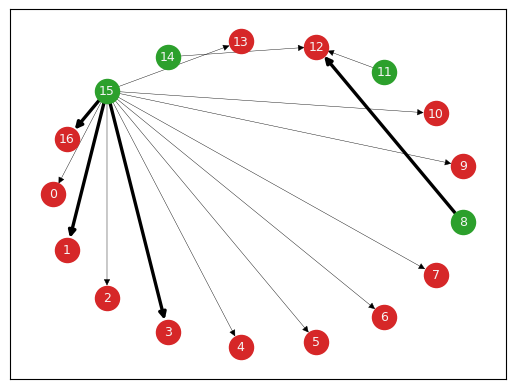

In [40]:
arg_selection, df_edges = analyze_a_topic(df_topics, show_data=False)
draw_graph(arg_selection, df_edges)

The plot shows that review #8, #11, #13 and #14 are supportive, while the others are defeated. Look back to the `arg_selection` table, those four reviews indeed had the highest level of consistence. Interestingly the score of #14 (negative) disagrees with those of #8, #11 and #13 (positive). The three nodes attack and defeat the single negative node with a lower coherence (#12) while #14 does the same with all positive nodes with a lower coherence. There are no nodes with a neutral score in this topic. 